# Implementation of Example 8.1 Dyna Maze in TextBook [Sutton] (pag. 164)

Algorithm is called Tabular Dyna-Qand it is a mix between planning & acting. 

Although it is called Dyna-Q, also it is a Q-planning algorithm with n-steps. 

If n = 0, it is a Q-learning algorithm.

Algorithm is shown below. If (f) = 0 then it is a Q-learning algorithm

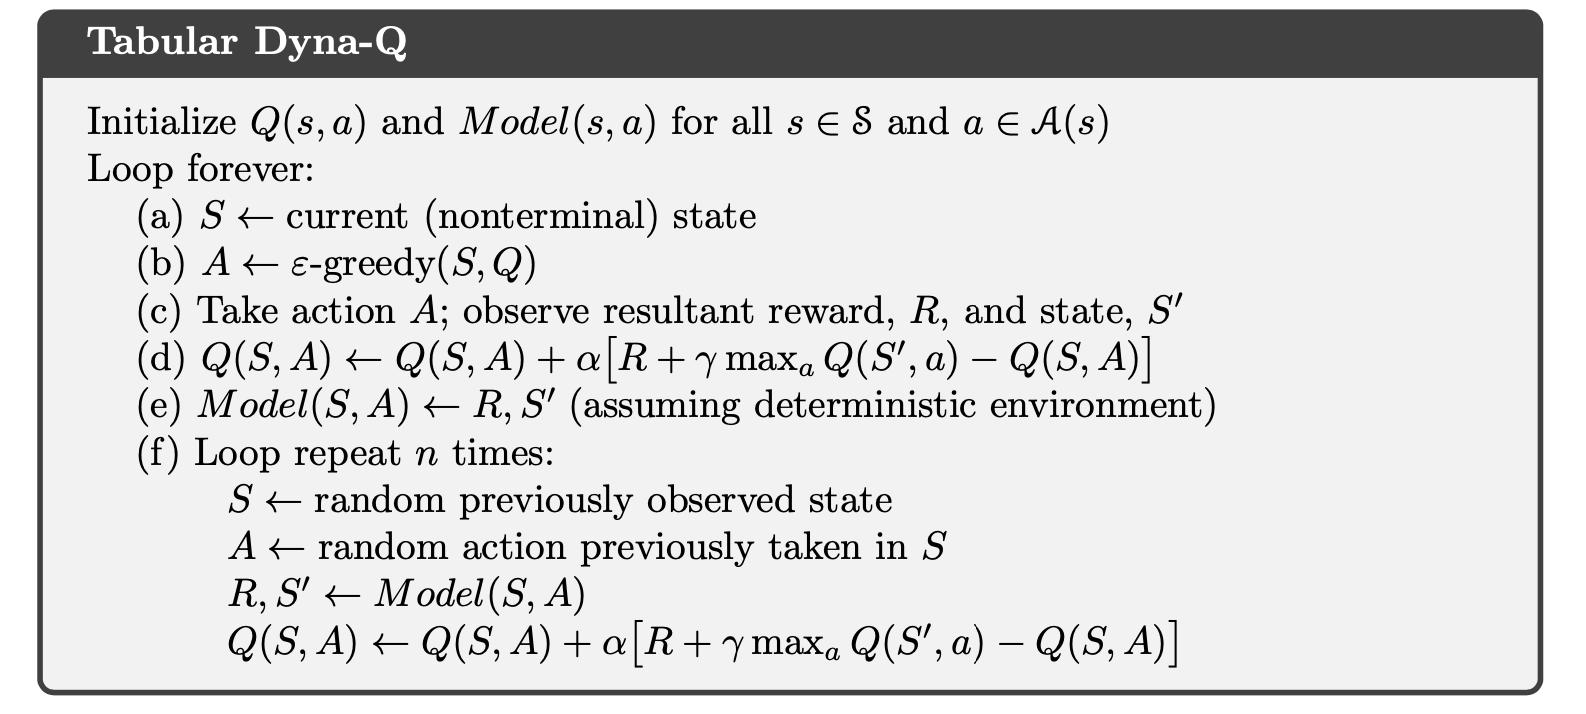

In [3]:
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from tqdm import tqdm
from copy import deepcopy
from matplotlib.table import Table


In [4]:
# la clase Maze que contiene la configuracion del laberinto. Es facilmente modificable para cambiar el espacio, los obstaculos y estados inciales y finales

# A wrapper class for a maze, containing all the information about the maze.
# Basically it's initialized to DynaMaze by default, however it can be easily adapted
# to other maze
class Maze:
    def __init__(self):
        # maze width
        self.WORLD_WIDTH = 9

        # maze height
        self.WORLD_HEIGHT = 6

        # all possible actions
        self.ACTION_UP = 0
        self.ACTION_DOWN = 1
        self.ACTION_LEFT = 2
        self.ACTION_RIGHT = 3
        self.actions = [self.ACTION_UP, self.ACTION_DOWN, self.ACTION_LEFT, self.ACTION_RIGHT]

        self.ACTIONS_FIGS=['↑', '↓', '←', '→']


        # start state
        self.START_STATE = [2, 0]

        # goal state
        self.GOAL_STATES = [[0, 8]]

        # all obstacles
        self.obstacles = [[1, 2], [2, 2], [3, 2], [0, 7], [1, 7], [2, 7], [4, 5]]
        self.old_obstacles = None
        self.new_obstacles = None

        # time to change obstacles
        self.obstacle_switch_time = None

        # initial state action pair values
        # self.stateActionValues = np.zeros((self.WORLD_HEIGHT, self.WORLD_WIDTH, len(self.actions)))

        # the size of q value
        self.q_size = (self.WORLD_HEIGHT, self.WORLD_WIDTH, len(self.actions))

        # max steps
        self.max_steps = float('inf')

        # track the resolution for this maze
        self.resolution = 1

    # extend a state to a higher resolution maze
    # @state: state in lower resoultion maze
    # @factor: extension factor, one state will become factor^2 states after extension
    #def extend_state(self, state, factor):
    #    new_state = [state[0] * factor, state[1] * factor]
    #    new_states = []
    #    for i in range(0, factor):
    #        for j in range(0, factor):
    #            new_states.append([new_state[0] + i, new_state[1] + j])
    #    return new_states

    # extend a state into higher resolution
    # one state in original maze will become @factor^2 states in @return new maze
    #def extend_maze(self, factor):
    #    new_maze = Maze()
    #    new_maze.WORLD_WIDTH = self.WORLD_WIDTH * factor
    #    new_maze.WORLD_HEIGHT = self.WORLD_HEIGHT * factor
    #    new_maze.START_STATE = [self.START_STATE[0] * factor, self.START_STATE[1] * factor]
    #    new_maze.GOAL_STATES = self.extend_state(self.GOAL_STATES[0], factor)
    #    new_maze.obstacles = []
    #    for state in self.obstacles:
    #        new_maze.obstacles.extend(self.extend_state(state, factor))
    #    new_maze.q_size = (new_maze.WORLD_HEIGHT, new_maze.WORLD_WIDTH, len(new_maze.actions))
        # new_maze.stateActionValues = np.zeros((new_maze.WORLD_HEIGHT, new_maze.WORLD_WIDTH, len(new_maze.actions)))
    #    new_maze.resolution = factor
    #    return new_maze

    # take @action in @state
    # @return: [new state, reward]
    def step(self, state, action):
        x, y = state
        if action == self.ACTION_UP:
            x = max(x - 1, 0)
        elif action == self.ACTION_DOWN:
            x = min(x + 1, self.WORLD_HEIGHT - 1)
        elif action == self.ACTION_LEFT:
            y = max(y - 1, 0)
        elif action == self.ACTION_RIGHT:
            y = min(y + 1, self.WORLD_WIDTH - 1)
        if [x, y] in self.obstacles:
            x, y = state
        if [x, y] in self.GOAL_STATES:
            reward = 1.0
        else:
            reward = 0.0
        return [x, y], reward

In [5]:
# Parametros del algoritmo
# a wrapper class for parameters of dyna algorithms
class DynaParams:
    def __init__(self):
        # discount
        self.gamma = 0.95

        # probability for exploration
        self.epsilon = 0.1

        # step size
        self.alpha = 0.1

        # weight for elapsed time
        self.time_weight = 0

        # n-step planning
        self.planning_steps = 5

        # average over several independent runs
        self.runs = 10

        # algorithm names
        self.methods = ['Dyna-Q', 'Dyna-Q+']

        # threshold for priority queue
        self.theta = 0

In [6]:
# Clase Modelo que nos servirá para ir guardando la informacion de estados y acciones. Asi es como trabaja este algoritmo, planning y Direct RL
# Trivial model for planning in Dyna-Q
class Model:
    # @rand: an instance of np.random.RandomState for sampling
    def __init__(self, rand=np.random):
        self.model = dict()
        self.rand = rand

    # feed the model with previous experience
    def feed(self, state, action, next_state, reward):
        state = deepcopy(state)
        next_state = deepcopy(next_state)
        if tuple(state) not in self.model.keys():
            self.model[tuple(state)] = dict()
        self.model[tuple(state)][action] = [list(next_state), reward]

    # randomly sample from previous experience
    def sample(self):
        state_index = self.rand.choice(range(len(self.model.keys())))
        state = list(self.model)[state_index]
        action_index = self.rand.choice(range(len(self.model[state].keys())))
        action = list(self.model[state])[action_index]
        next_state, reward = self.model[state][action]
        state = deepcopy(state)
        next_state = deepcopy(next_state)
        return list(state), action, list(next_state), reward

In [7]:
# choose an action based on epsilon-greedy algorithm
def choose_action(state, q_value, maze, dyna_params):
    if np.random.binomial(1, dyna_params.epsilon) == 1:
        #print("------ entre en el 1 ---------")
        return np.random.choice(maze.actions)
    else:
        #print("------ entre en el 2 ---------")
        values = q_value[state[0], state[1], :]
        #print("values:", values)
        #a = np.random.choice([action for action, value in enumerate(values) if value == np.max(values)])
        #print("action es :", a)
        return np.random.choice([action for action, value in enumerate(values) if value == np.max(values)])


In [8]:
# play for an episode for Dyna-Q algorithm
# @q_value: state action pair values, will be updated
# @model: model instance for planning
# @maze: a maze instance containing all information about the environment
# @dyna_params: several params for the algorithm
def steps_dyna_q(q_value, model, maze, dyna_params):
    state = maze.START_STATE
    steps = 0
    while state not in maze.GOAL_STATES:
        # track the steps
        steps += 1

        # get action
        action = choose_action(state, q_value, maze, dyna_params)

        # take action
        next_state, reward = maze.step(state, action)

        # Q-Learning update
        q_value[state[0], state[1], action] += \
            dyna_params.alpha * (reward + dyna_params.gamma * np.max(q_value[next_state[0], next_state[1], :]) -
                                 q_value[state[0], state[1], action])
        #print("---------- FIRST q_value -> :", q_value)

        # feed the model with experience
        model.feed(state, action, next_state, reward)

        # sample experience from the model
        for t in range(0, dyna_params.planning_steps):
            #print('t ---->', t)

            state_, action_, next_state_, reward_ = model.sample()
            q_value[state_[0], state_[1], action_] += \
                dyna_params.alpha * (reward_ + dyna_params.gamma * np.max(q_value[next_state_[0], next_state_[1], :]) -
                                     q_value[state_[0], state_[1], action_])
            #print(" q_value en", t, "--> q_value[state[0], state[1], action]:", q_value[state_[0], state_[1], action_])
        #print("q_value:", q_value)
        state = next_state

        # check whether it has exceeded the step limit
        if steps > maze.max_steps:
            break

    print("q_value.shape:", q_value.shape)
    print("len(q_value):", len(q_value))
    print("q_value.ndim:", q_value.ndim)
    print("q_value.size:", q_value.size)
    print("q_value.dtype:", q_value.dtype)
    print("q_value.dype.name:", q_value.dtype.name)
    print("q_value:", q_value)
    q_value_normalized = np.zeros((maze.WORLD_HEIGHT, maze.WORLD_WIDTH))
    q_value_normalized = q_value.max(axis=2)
    print("q_value_normalized:",q_value_normalized)


    return steps
    #return steps, [q_value]

In [13]:
# play for an episode for Dyna-Q algorithm
# @q_value: state action pair values, will be updated
# @model: model instance for planning
# @maze: a maze instance containing all information about the environment
# @dyna_params: several params for the algorithm
def Qvalue_dyna_q(q_value, model, maze, dyna_params):
    state = maze.START_STATE
    steps = 0
    while state not in maze.GOAL_STATES:
        # track the steps
        steps += 1

        # get action
        action = choose_action(state, q_value, maze, dyna_params)

        # take action
        next_state, reward = maze.step(state, action)

        # Q-Learning update
        q_value[state[0], state[1], action] += \
            dyna_params.alpha * (reward + dyna_params.gamma * np.max(q_value[next_state[0], next_state[1], :]) -
                                 q_value[state[0], state[1], action])
        #print("---------- FIRST q_value -> :", q_value)

        # feed the model with experience
        model.feed(state, action, next_state, reward)

        # sample experience from the model
        for t in range(0, dyna_params.planning_steps):
            #print('t ---->', t)

            state_, action_, next_state_, reward_ = model.sample()
            q_value[state_[0], state_[1], action_] += \
                dyna_params.alpha * (reward_ + dyna_params.gamma * np.max(q_value[next_state_[0], next_state_[1], :]) -
                                     q_value[state_[0], state_[1], action_])
            #print(" q_value en", t, "--> q_value[state[0], state[1], action]:", q_value[state_[0], state_[1], action_])
        #print("q_value:", q_value)
        state = next_state

        # check whether it has exceeded the step limit
        if steps > maze.max_steps:
            break


    #print("q_value:", q_value)
    #return steps
    return q_value

In [10]:
def figure_3_5():
    value = np.zeros((dyna_maze.WORLD_HEIGHT, dyna_maze.WORLD_WIDTH))
    while True:
        # keep iteration until convergence
        new_value = np.zeros_like(value)
        for i in range(dyna_maze.WORLD_HEIGHT):
            for j in range(dyna_maze.WORLD_WIDTH):
                values = []
                for action in dyna_maze.actions:
                    (next_i, next_j), reward = step([i, j], action)
                    # value iteration
                    values.append(reward + DISCOUNT * value[next_i, next_j])
                new_value[i, j] = np.max(values)
        if np.sum(np.abs(new_value - value)) < 1e-4:
            draw_image(np.round(new_value, decimals=2))
            plt.savefig('../images/figure_3_5.png')
            plt.close()
            draw_policy(new_value)
            plt.savefig('../images/figure_3_5_policy.png')
            plt.close()
            break
        value = new_value


In [11]:
def draw_image(image):
    fig, ax = plt.subplots()
    ax.set_axis_off()
    tb = Table(ax, bbox=[0, 0, 1, 1])

    nrows, ncols = image.shape
    width, height = 1.0 / ncols, 1.0 / nrows

    # Add cells
    for (i, j), val in np.ndenumerate(image):

        # add state labels
        if [i, j] == A_POS:
            val = str(val) + " (A)"
        if [i, j] == A_PRIME_POS:
            val = str(val) + " (A')"
        if [i, j] == B_POS:
            val = str(val) + " (B)"
        if [i, j] == B_PRIME_POS:
            val = str(val) + " (B')"
        
        tb.add_cell(i, j, width, height, text=val,
                    loc='center', facecolor='white')
        

    # Row and column labels...
    for i in range(len(image)):
        tb.add_cell(i, -1, width, height, text=i+1, loc='right',
                    edgecolor='none', facecolor='none')
        tb.add_cell(-1, i, width, height/2, text=i+1, loc='center',
                    edgecolor='none', facecolor='none')

    ax.add_table(tb)

In [14]:
if __name__ == '__main__':


    # set up an instance for DynaMaze
    dyna_maze = Maze()
    dyna_params = DynaParams()

    runs = 2 # 10 originally
    episodes = 10 # 50 originally
    #planning_steps = [0, 5, 50]
    #planning_steps = [0, 5]
    planning_steps = [0]
    steps = np.zeros((len(planning_steps), episodes))
    steps_2 = np.zeros((len(planning_steps), episodes))
    q_values = np.zeros((len(planning_steps), episodes))


    #EMPEZAMOS LOS EPISODIOS PARA CADA PLANIFICACION DE N-STEPS
    for run in tqdm(range(runs)):
        for i, planning_step in enumerate(planning_steps):
            dyna_params.planning_steps = planning_step
            q_value = np.zeros(dyna_maze.q_size)

            # generate an instance of Dyna-Q model
            model = Model()
            for ep in range(episodes):
                print('\nrun:', run, 'planning step:', planning_step, 'episode:', ep, "dyna_params.planning_steps:", dyna_params.planning_steps)
                #steps_2[i, ep], q_values[i, ep] = dyna_q(q_value, model, dyna_maze, dyna_params)
                steps[i, ep] += steps_dyna_q(q_value, model, dyna_maze, dyna_params)
                #q_values[i, ep] = Qvalue_dyna_q(q_value, model, dyna_maze, dyna_params) 
                print("steps[", i,",", ep,"]", steps[i, ep])

            #print("\n-------------------")    
            #print("steps --->:", steps)


    # Dibujamos la matriz con los valores para cada celda
    print("\n steps --->:", steps)


    # Dibujamos la matriz con la politica para cada estado



    # averaging over runs
    steps /= runs
    #print("steps avereged: ", steps)

    for i in range(len(planning_steps)):
        plt.plot(steps[i, :], label='%d planning steps' % (planning_steps[i]))
    plt.xlabel('episodes')
    plt.ylabel('steps per episode')
    plt.legend()
    plt.show()
    #plt.savefig('../images/figure_8_2.png')
    plt.close()

  0%|          | 0/2 [00:00<?, ?it/s]


run: 0 planning step: 0 episode: 0 dyna_params.planning_steps: 0
q_value.shape: (6, 9, 4)
len(q_value): 6
q_value.ndim: 3
q_value.size: 216
q_value.dtype: float64
q_value.dype.name: float64
q_value: [[[0.  0.  0.  0. ]
  [0.  0.  0.  0. ]
  [0.  0.  0.  0. ]
  [0.  0.  0.  0. ]
  [0.  0.  0.  0. ]
  [0.  0.  0.  0. ]
  [0.  0.  0.  0. ]
  [0.  0.  0.  0. ]
  [0.  0.  0.  0. ]]

 [[0.  0.  0.  0. ]
  [0.  0.  0.  0. ]
  [0.  0.  0.  0. ]
  [0.  0.  0.  0. ]
  [0.  0.  0.  0. ]
  [0.  0.  0.  0. ]
  [0.  0.  0.  0. ]
  [0.  0.  0.  0. ]
  [0.1 0.  0.  0. ]]

 [[0.  0.  0.  0. ]
  [0.  0.  0.  0. ]
  [0.  0.  0.  0. ]
  [0.  0.  0.  0. ]
  [0.  0.  0.  0. ]
  [0.  0.  0.  0. ]
  [0.  0.  0.  0. ]
  [0.  0.  0.  0. ]
  [0.  0.  0.  0. ]]

 [[0.  0.  0.  0. ]
  [0.  0.  0.  0. ]
  [0.  0.  0.  0. ]
  [0.  0.  0.  0. ]
  [0.  0.  0.  0. ]
  [0.  0.  0.  0. ]
  [0.  0.  0.  0. ]
  [0.  0.  0.  0. ]
  [0.  0.  0.  0. ]]

 [[0.  0.  0.  0. ]
  [0.  0.  0.  0. ]
  [0.  0.  0.  0. ]
  [0.  0.  0

 50%|█████     | 1/2 [00:00<00:00,  1.52it/s]


q_value_normalized: [[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  5.69532790e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 6.98337296e-09 0.00000000e+00
  1.77550507e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 6.98337296e-09 5.36617080e-07 1.81142117e-05
  3.43778405e-02]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 3.51581623e-04
  4.30775208e-03]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  3.74672875e-05]]
steps[ 0 , 7 ] 46.0

run: 0 planning step: 0 episode: 8 dyna_params.planning_steps: 0
q_value.shape: (6, 9, 4)
len(q_value): 6

100%|██████████| 2/2 [00:01<00:00,  1.81it/s]

q_value.shape: (6, 9, 4)
len(q_value): 6
q_value.ndim: 3
q_value.size: 216
q_value.dtype: float64
q_value.dype.name: float64
q_value: [[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]]

 [[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00


<ipython-input-14-81aebf662432>:54: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
